In [ ]:
# To generate GIFs
!pip install imageio
!pip install h5py
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-3otaj657
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-3otaj657
  Resolved https://github.com/tensorflow/docs to commit 008b2116a3e6674dca5c988948982cdaa45517b2
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.9.4.19335-py3-none-any.whl size=184104 sha256=545107061c37ad606ec6a269464070b39ed5c917cd6b032e5e08bfaf3044d2b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-y9ejdzuo/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import time

from IPython import display

### Load and prepare the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import PIL.Image
from google.colab import drive

def resize_and_save_images(input_folder, output_dir, width, height):
  # Conecta tu cuenta de Google Drive a Colab.
  drive.mount("/content/drive")

  # Obtiene la ruta completa de la carpeta de entrada.
  input_folder_path = os.path.join("/content/drive/My Drive", input_folder)

  # Lista todas las imágenes en la carpeta de entrada.
  images = os.listdir(input_folder_path)

  # Redimensiona cada imagen.
  for image_file in images:
    image_path = os.path.join(input_folder_path, image_file)
    image = PIL.Image.open(image_path)
    image = image.resize((width, height), resample=PIL.Image.LANCZOS)

    # Guarda la imagen redimensionada en la carpeta de salida.
    output_path = os.path.join(output_dir, image_file)
    image.save(output_path)

# Ejemplo de uso:

input_folder = "/content/drive/MyDrive/UN/Galaxy_THIS"
output_dir = "/content/drive/MyDrive/UN/Galaxy_resize"
width = 512
height = 512

resize_and_save_images(input_folder, output_dir, width, height)


In [ ]:
from PIL import Image
import os
import numpy as np

# Ruta de la carpeta de imágenes en Google Drive
image_folder_path = '/content/drive/MyDrive/UN/Galaxy_resize'

# Lista para almacenar las imágenes
images = []

# Recorriendo la carpeta de imágenes y agregando las imágenes a la lista
for filename in os.listdir(image_folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
        img_path = os.path.join(image_folder_path, filename)
        img = Image.open(img_path)
        img = np.array(img)  # Convertir la imagen en un array de NumPy
        images.append(img)

# Convirtiendo la lista en un array de NumPy
images = np.array(images)

# Verificando las dimensiones de las imágenes
print(f"Dimensiones de las imágenes: {images.shape}")


Dimensiones de las imágenes: (66, 512, 512, 3)


In [ ]:
train_images = images.astype(np.float32)/255

In [ ]:
print(images.shape)

(66, 512, 512, 3)


In [ ]:
BUFFER_SIZE = 6000
BATCH_SIZE = 21
noise_dim  = 500

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

### The Generator

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(noise_dim ,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 1024)))
    assert model.output_shape == (None, 8, 8, 1024)

    model.add(layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.PReLU())

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.PReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 256, 256, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.PReLU())

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 512, 512, 3)

    return model


(1, 512, 512, 3)


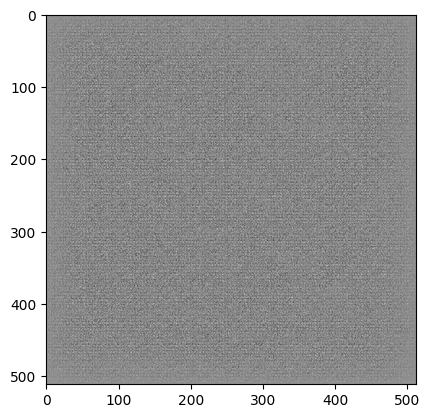

In [ ]:
generator = make_generator_model()
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
print( generated_image.shape)

### The Discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[512, 512, 3]))
    model.add(layers.PReLU())

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.PReLU())

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.PReLU())

    model.add(layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.PReLU())
    model.add(layers.Dense(1))

    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[512, 512, 3]))
    model.add(layers.ELU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.PReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ELU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ELU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-6.0929025e-05]], shape=(1, 1), dtype=float32)


##loss and optimizers

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

###**Checkpoints**

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training loop


In [ ]:
EPOCHS = 400
noise_dim = noise_dim
num_examples_to_generate = 2

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6, 12))

  for i in range(predictions.shape[0]):
      plt.subplot(1, 2, i+1)
      Lsuma = np.dstack((predictions[i,:, :, 0], predictions[i,:, :, 1], predictions[i,:, :, 2]))
      plt.imshow(Lsuma)
      #plt.imshow(predictions[i, :, :, 0], cmap='gray')
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

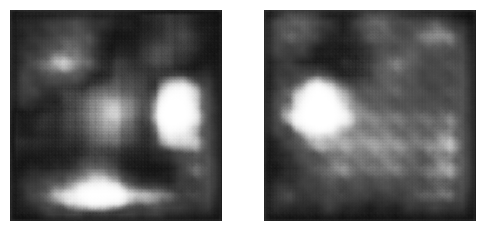

In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

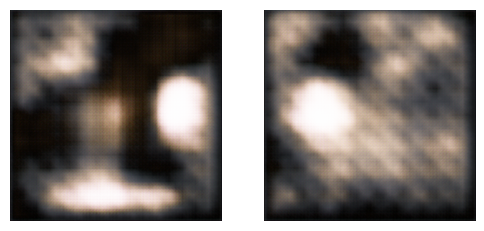

Time for epoch 401 is 5.30411696434021 sec


KeyboardInterrupt: ignored

In [ ]:
start = time.time()
for image_batch in train_dataset:
  train_step(image_batch)
  # Produce images for the GIF as you go
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                             400 + 1,
                             seed)

    # Save the model every 15 epochs
  if (400 + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  print ('Time for epoch {} is {} sec'.format(400 + 1, time.time()-start))

  # Generate after the final epoch
display.clear_output(wait=True)
generate_and_save_images(generator,
                           400,
                           seed)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

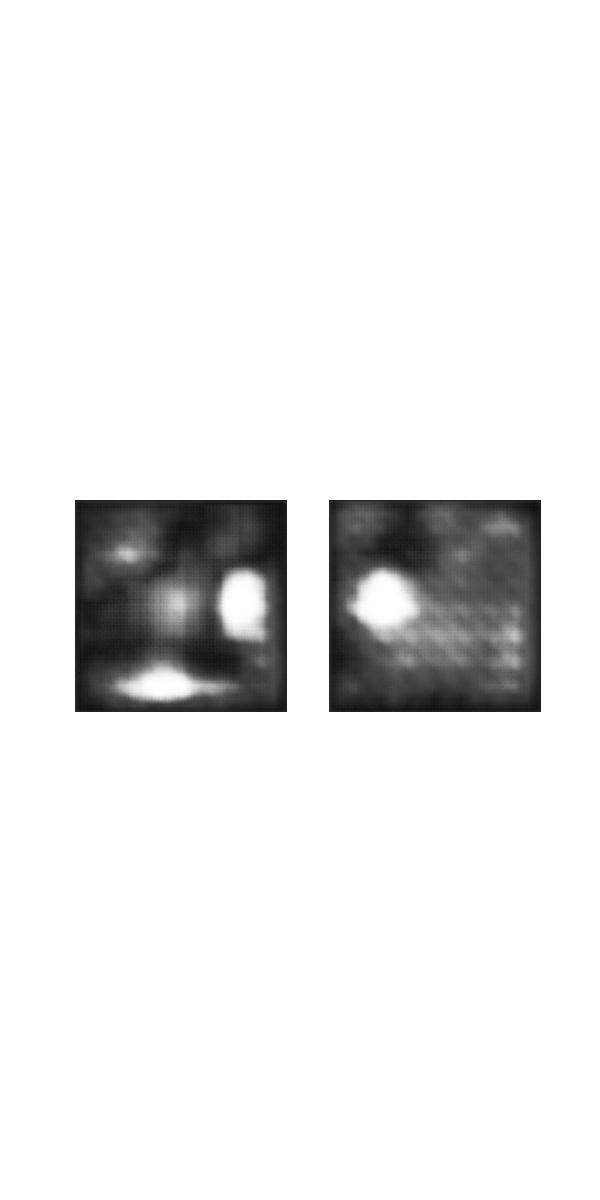

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image_at_epoch*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-159-3b9e9d67222e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-159-3b9e9d67222e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



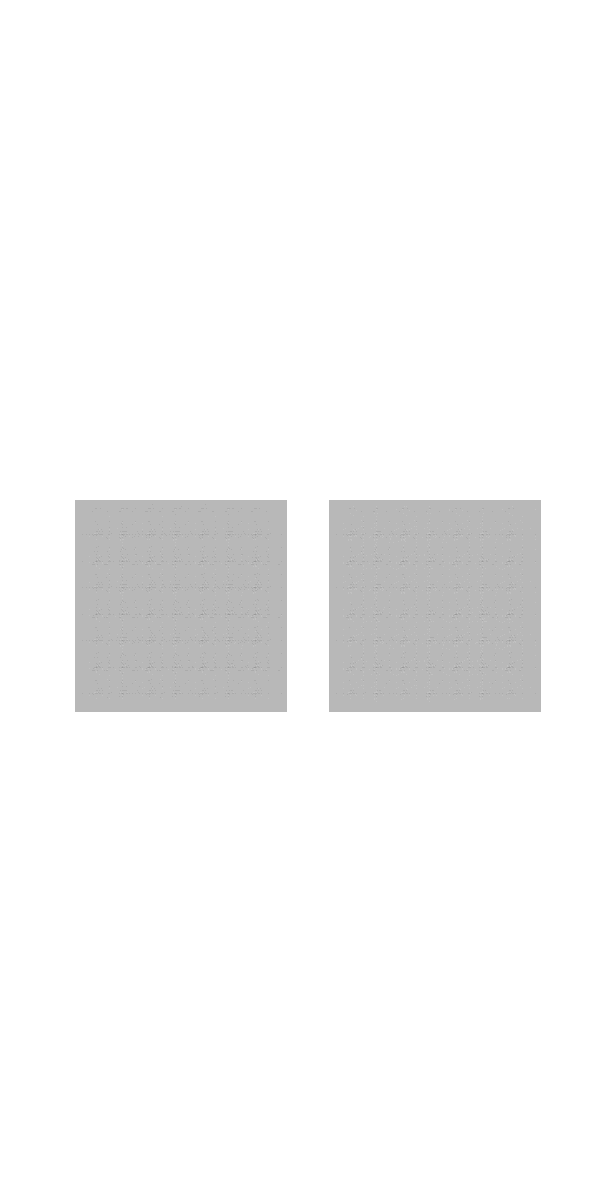

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)